In [178]:
%run ../robustness_analysis.ipynb

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state, seed=None):
        self.seed(seed)
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

In [3]:
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([masscart, force_mag])

# define the range of the initial states
x0_bounds = np.repeat([[-0.05, 0.05]], 4, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
])

In [4]:
def env_builder(delta):
    return MutatedCartPoleEnv(masscart=delta[0], force_mag=delta[1]), x0_bounds

In [5]:
# credits to: https://gist.github.com/HenryJia/23db12d61546054aa43f8dc587d9dc2c
class PID:
    def __init__(self):
        self.desired_state = np.array([0, 0, 0, 0])
        self.desired_mask = np.array([0, 0, 1, 0])
        self.P, self.I, self.D = 0.1, 0.01, 0.5
        
        self.reset()
    
    def reset(self):
        self.integral = 0
        self.derivative = 0
        self.prev_error = 0
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def next_action(self, obs):
        error = obs - self.desired_state

        self.integral += error
        self.derivative = error - self.prev_error
        self.prev_error = error

        pid = np.dot(self.P * error + self.I * self.integral + self.D * self.derivative, self.desired_mask)
        action = self.sigmoid(pid)
        return np.round(action).astype(np.int32)

In [6]:
model = PID()

agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: model.next_action(obs),

    # some agents (like PID) needs to be reset for each run
    'model_reset': lambda : model.reset()
}

In [7]:
obs_space = MutatedCartPoleEnv().observation_space
pos_range = np.asarray([obs_space.low[0], obs_space.high[0]])
angle_range = np.asarray([obs_space.low[2], obs_space.high[2]])

def stl_prop():
    pos = stl.Predicate('pos')
    angle = stl.Predicate('angle')

    pos_threshold = normalize(2.4, pos_range)
    angle_threshold = normalize(12 * 2 * np.pi / 360, angle_range)

    return stl.Always( (pos < pos_threshold) & (angle < angle_threshold) )


def signal_builder(record, time_index):
    return {
        "pos": stl.Signal(
            normalize(np.abs(record[:, 0]), pos_range),
            time_index
        ),
        "angle": stl.Signal(
            normalize(np.abs(record[:, 2]), angle_range),
            time_index
        )
    }

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

In [8]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

In [9]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')
if not os.path.exists('data'):
    os.mkdir('data')

In [10]:
from datetime import datetime

In [179]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['falsification_num_trials'] = 1
analysis.options

{'epsilon': 0.01,
 'deviation_num_trials': 3,
 'deviation_sigma': 0.2,
 'deviation_timeout': 10,
 'falsification_sigma': 0.2,
 'falsification_timeout': 1,
 'falsification_num_trials': 1,
 'falsification_episodes': 100,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 200}

In [12]:
start = datetime.now()
delta, delta_dist = analysis.any_unsafe_deviation()


================ Any unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=1008736, Sat Nov 19 20:43:02 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.875263979007519e-01 1.0e+00 1.72e-01  2e-01  2e-01 0:05.6
    2     12 1.073066522647655e-01 1.2e+00 1.87e-01  2e-01  2e-01 0:11.3
    3     18 1.573163797427929e-01 1.6e+00 1.85e-01  2e-01  2e-01 0:16.9


/home/cj/miniconda3/envs/rl_robust/lib/python3.7/site-packages/gym/envs/classic_control/cartpole.py:151: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


    4     24 -9.575212697488900e-02 1.5e+00 2.17e-01  2e-01  2e-01 0:22.5
termination on ftarget=0.0 (Sat Nov 19 20:43:26 2022)
final/bestever f-value = -2.073307e-02 -9.575213e-02
incumbent solution: [0.031839402442152276, 0.7652655866621012]
std deviation: [0.21233810547812912, 0.20932308566534175]


In [13]:
print('Time to find any unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

Time to find any unsafe deviation: 0:00:23.429036
[ 0.1212535  15.74321661] 0.5525164754923121


STL robustness value: -0.095752126974889
Initial state: [ 0.00094625 -0.04466195  0.01559568 -0.02385885]


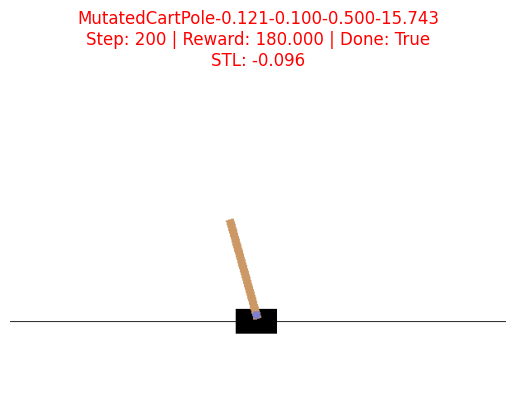

In [14]:
analysis.visualize_deviation(delta, "gifs/any_counterexample.gif")

In [15]:
start = datetime.now()
delta, delta_dist = analysis.min_unsafe_deviation()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=952191, Sat Nov 19 20:43:42 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 3.577056320814740e-02 1.0e+00 1.84e-01  2e-01  2e-01 0:06.2
    2     12 3.576763226466072e-02 1.2e+00 1.57e-01  1e-01  1e-01 0:12.3
    3     18 3.577739502715576e-02 1.6e+00 1.74e-01  2e-01  2e-01 0:18.0
    4     24 3.577304333104316e-02 1.2e+00 1.82e-01  1e-01  2e-01 0:23.6
    5     30 3.576826353464976e-02 1.5e+00 1.80e-01  1e-01  2e-01 0:29.1
    6     36 3.576792535360571e-02 1.3e+00 1.41e-01  9e-02  1e-01 0:34.6
    8     48 3.576812826204030e-02 1.8e+00 1.60e-01  1e-01  1e-01 0:45.8
   10     60 3.576963882069929e-02 1.4e+00 1.98e-01  1e-01  1e-01 0:57.3
   12     72 1.725083171224902e-01 1.5e+00 2.30e-01  2e-01  2e-01 1:09.1
   14     84 1.146281974662349e-01 1.4e+00 2.62e-01  1e-01  2e-01 1:20.7
   16     96 7.715307445376948e-02 2.3e+00 1.

   73    438 3.775361393817275e+01 1.3e+00 2.39e-03  5e-05  6e-05 7:14.1
   78    468 5.781143083996200e+01 1.9e+00 2.65e-03  6e-05  7e-05 7:44.9
   83    498 8.874852200653730e+01 2.8e+00 1.78e-03  4e-05  4e-05 8:14.6
   88    528 1.364607641787746e+02 2.7e+00 2.58e-03  5e-05  6e-05 8:45.5
   94    564 2.289976681535377e+02 1.8e+00 2.16e-03  3e-05  6e-05 9:20.7
  100    600 3.846002377150836e+02 2.0e+00 3.57e-03  6e-05  9e-05 9:58.0
  101    606 4.193327695083400e+02 1.8e+00 3.57e-03  7e-05  8e-05 10:04.2
termination on timeout=600 (Sat Nov 19 21:10:41 2022)
final/bestever f-value = 4.578321e+02 2.190204e-02
incumbent solution: [0.4738740903290766, 0.4737402707892204]
std deviation: [6.73038228227035e-05, 8.126070063304182e-05]
CMAEvolutionStrategyResult(xbest=array([0.14325774, 0.59734089]), fbest=0.02190204017896873, evals_best=30, evaluations=607, iterations=101, xfavorite=array([0.47387409, 0.47374027]), stds=array([6.73038228e-05, 8.12607006e-05]), stop={'timeout': 600})
{'x': ar

In [16]:
print('Time to find min unsafe deviation:', datetime.now() - start)
print(delta, delta_dist)

Time to find min unsafe deviation: 0:26:58.715721
[1.49998227 3.08034814] 0.4493140628140719


STL robustness value: -0.250000009934107
Initial state: [-0.02602456  0.03079336 -0.04835666 -0.03870632]


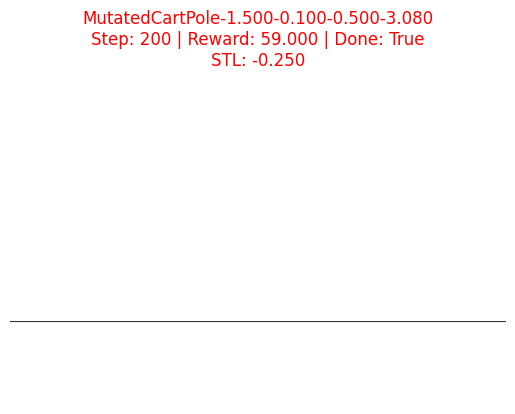

In [17]:
analysis.visualize_deviation(delta, "gifs/min_counterexample.gif")

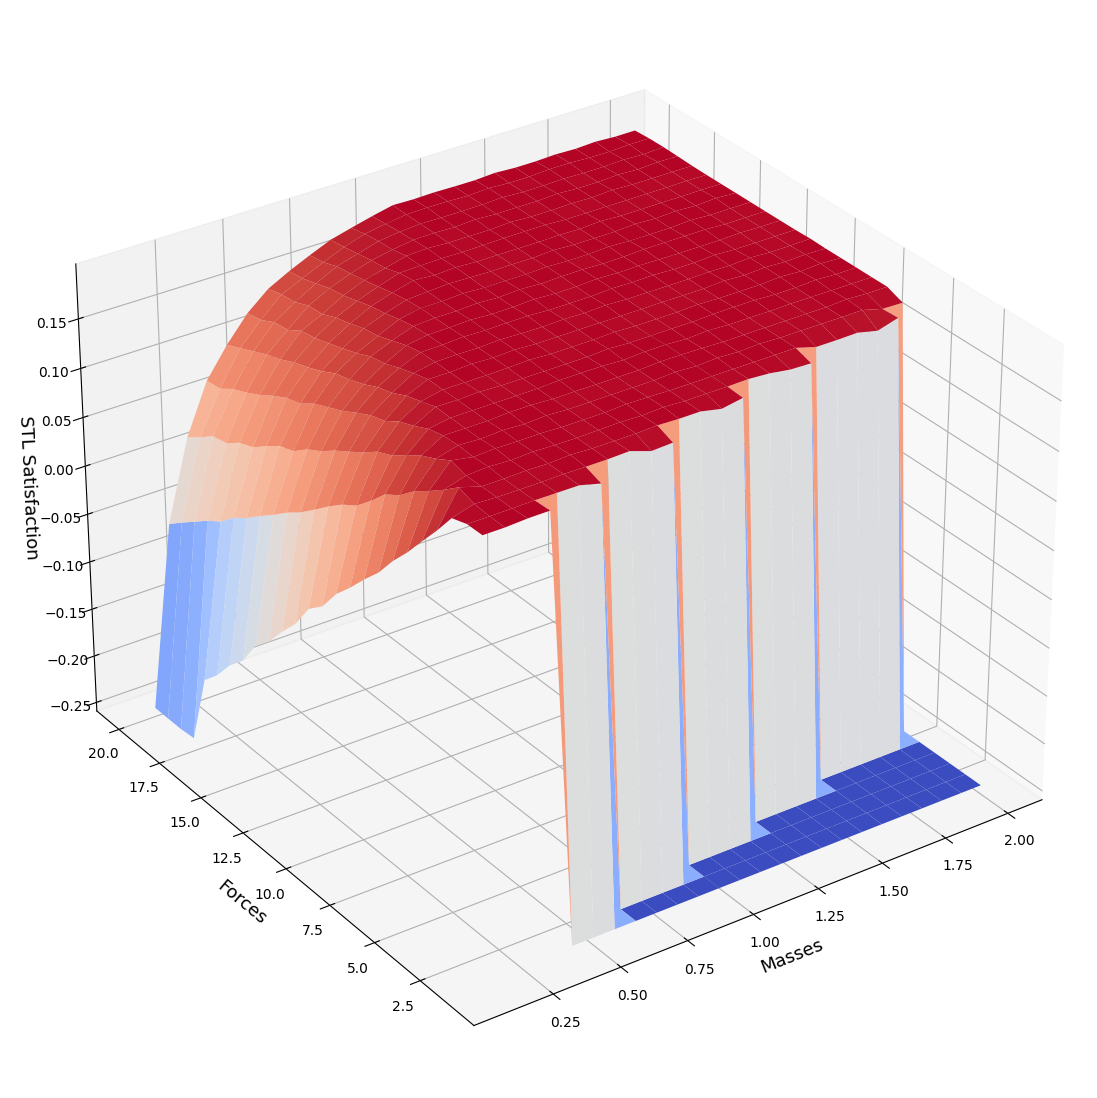

In [186]:
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces",
                                                   z_name="STL Satisfaction")
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape.png', bbox_inches='tight')
plt.show()

In [181]:
# fig, ax = plt.subplots()
# im = ax.imshow(grid_data, cmap=cm.coolwarm)
# ax.set_xticks(np.arange(0, len(forces[0]), 3), labels=['{:.2f}'.format(x) for x in forces[0][::3]])
# ax.set_yticks(np.arange(0, len(masses[:, 0]), 3), labels=['{:.2f}'.format(x) for x in masses[:, 0][::3]])
# cbar = ax.figure.colorbar(im)
# cbar.ax.set_ylabel('STL Satisfaction', rotation=-90, va="bottom")

# ax.set_xlabel('Forces')
# ax.set_ylabel('Masses')

# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# plt.savefig('gifs/robustness-landscape-heatmap.png')
# plt.show()

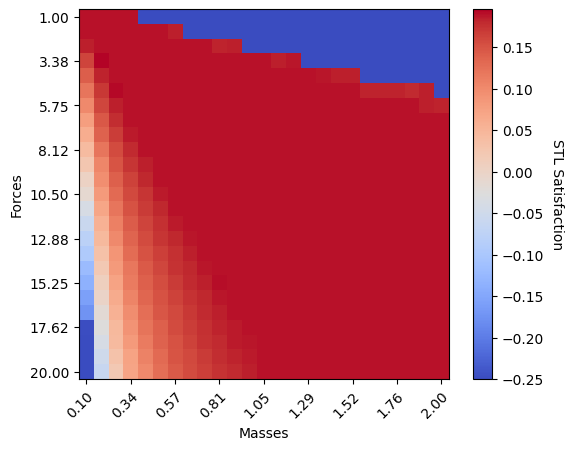

In [187]:
analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="STL Satisfaction")
plt.savefig('gifs/robustness-landscape-heatmap.png', bbox_inches='tight')
plt.show()

In [19]:
start = datetime.now()
boundary = analysis.robustness_boundary()


================ Min unsafe deviation trial 1 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=1031517, Sat Nov 19 21:10:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 3.576783517226397e-02 1.0e+00 2.63e-01  2e-01  4e-01 0:06.2
    2     12 3.577719209243820e-02 1.7e+00 2.10e-01  2e-01  3e-01 0:12.1
    3     18 9.145695491297119e-02 1.8e+00 1.90e-01  1e-01  2e-01 0:17.8
    4     24 -5.339541060685411e+01 1.9e+00 2.93e-01  2e-01  4e-01 0:23.4
    5     30 6.585616022076364e-01 2.1e+00 2.93e-01  2e-01  4e-01 0:29.3
    6     36 4.394428039376759e-01 2.2e+00 2.86e-01  2e-01  3e-01 0:35.2
    8     48 7.059752119574475e-01 1.9e+00 3.15e-01  2e-01  4e-01 0:46.8
   10     60 -3.920629391742020e-01 2.2e+00 4.92e-01  3e-01  6e-01 0:58.2
   12     72 -2.977151691634470e-01 3.5e+00 5.59e-01  3e-01  8e-01 1:09.8
   14     84 -3.319176421424501e-01 3.2e+00 3.40e-01  2e-01  4e-01 1:20.9
   17    102 -1.756187541964048e-01 3.0e

   50    300 1.768165447561728e-01 1.7e+00 1.59e-01  2e-02  4e-02 4:42.0
   54    324 2.106026547649827e-01 1.6e+00 1.05e-01  1e-02  1e-02 5:04.4
   58    348 2.667578346443194e-01 1.3e+00 4.54e-02  4e-03  4e-03 5:26.7
   63    378 3.760691990375649e-01 1.2e+00 1.79e-02  8e-04  9e-04 5:54.7
   68    408 5.473108921732802e-01 1.6e+00 1.03e-02  3e-04  4e-04 6:22.7
   73    438 8.126591309423745e-01 2.3e+00 8.79e-03  2e-04  3e-04 6:50.9
   78    468 1.221729750972028e+00 2.9e+00 3.74e-03  5e-05  1e-04 7:18.9
   83    498 1.852995087891457e+00 4.2e+00 2.75e-03  2e-05  7e-05 7:47.0
   88    528 2.826046158218415e+00 4.0e+00 9.03e-04  4e-06  2e-05 8:15.1
   90    540 3.350236859411905e+00 4.1e+00 6.11e-04  2e-06  8e-06 8:26.3
termination on tolx=1e-05 (Sat Nov 19 21:39:40 2022)
final/bestever f-value = 3.647999e+00 6.966501e-03
incumbent solution: [0.4736759099029797, 0.47368736351991103]
std deviation: [8.303847767745014e-06, 2.336682036040307e-06]
CMAEvolutionStrategyResult(xbest=array([0.

    7     42 3.577863519626863e-02 1.5e+00 2.09e-01  1e-01  2e-01 0:41.5
    9     54 3.576765480992155e-02 1.9e+00 2.23e-01  2e-01  2e-01 0:53.3
   11     66 4.608826037636596e-03 1.5e+00 1.75e-01  1e-01  2e-01 1:04.9
   13     78 1.794969323716218e-02 1.2e+00 1.46e-01  9e-02  1e-01 1:15.5
   16     96 2.899862698337264e-03 1.1e+00 7.20e-02  4e-02  4e-02 1:30.5
   19    114 1.875927746287138e-03 1.3e+00 4.29e-02  1e-02  2e-02 1:46.6
   22    132 1.734742117903872e-04 1.5e+00 6.34e-02  2e-02  2e-02 2:04.0
   25    150 3.756574341954460e-04 1.7e+00 5.39e-02  2e-02  2e-02 2:20.7
   28    168 4.380259775012051e-04 2.1e+00 3.33e-02  8e-03  1e-02 2:38.2
   31    186 1.727997432217404e-04 2.3e+00 2.69e-02  6e-03  8e-03 2:56.4
   34    204 1.702048903998664e-04 2.4e+00 1.84e-02  3e-03  5e-03 3:13.9
   37    222 1.069747315480676e-04 2.5e+00 1.99e-02  3e-03  5e-03 3:31.0
   41    246 1.134502555891694e-04 3.2e+00 1.18e-02  1e-03  2e-03 3:53.3
   45    270 1.063339937484845e-04 2.8e+00 3.02e-02

In [22]:
print(boundary)

0.3564224000568847


In [20]:
print('Time to approximate boundary:', datetime.now() - start)

Time to approximate boundary: 0:58:57.318272


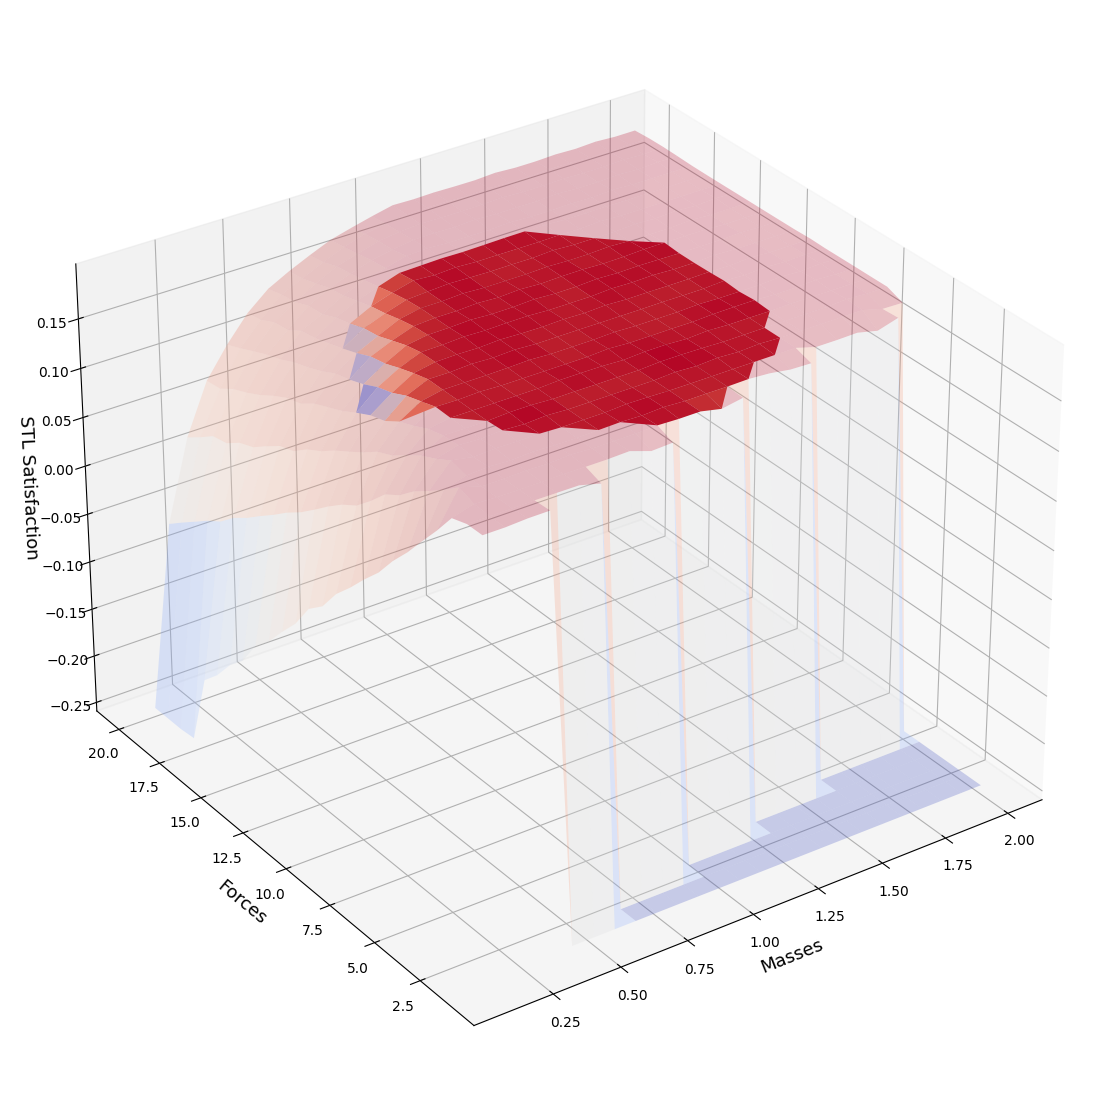

In [188]:
ax, masses, forces, grid_data = analysis.grid_plot(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces",
                                                   z_name='STL Satisfaction', boundary=boundary)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-boundary.png', bbox_inches='tight')
plt.show()

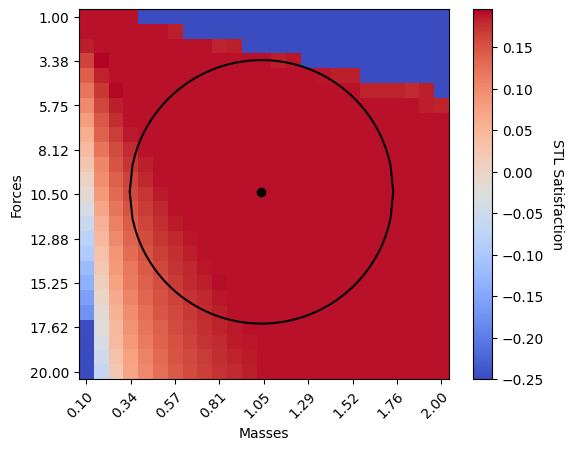

In [189]:
analysis.heatmap(masscart, force_mag, 25, 25, x_name="Masses", y_name="Forces", z_name="STL Satisfaction",
                 boundary=boundary)
plt.savefig('gifs/robustness-landscape-boundary-heatmap.png', bbox_inches='tight')
plt.show()

In [19]:
def episode_eval_reward(obs_record, reward_record):
    return reward_record.sum() - 200

In [20]:
analysis_reward = RobustnessAnalysis(env_builder, agent, episode_eval_reward, delta_0, dev_bounds, dist)
analysis_reward.options['falsification_num_trials'] = 1

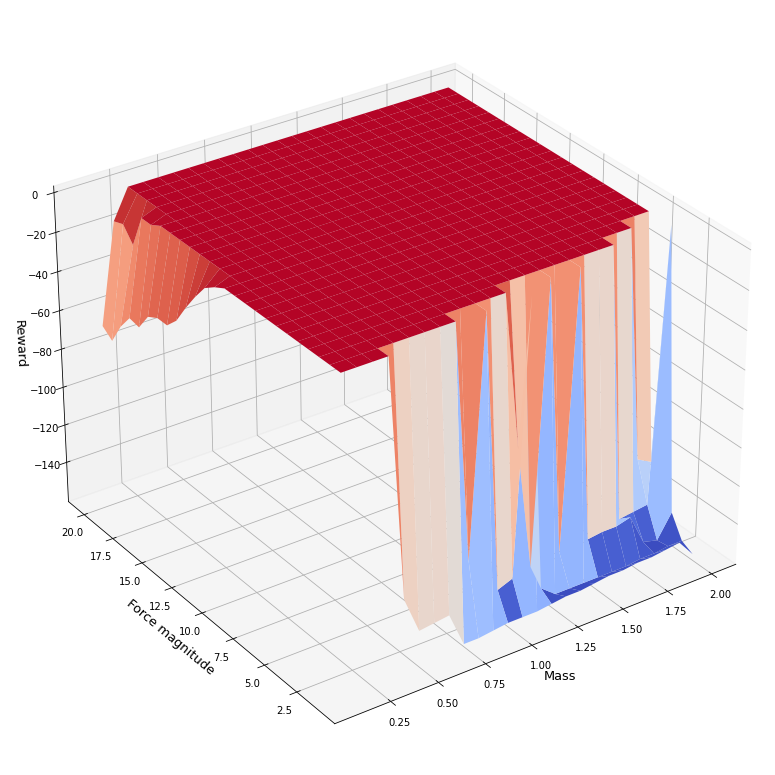

In [21]:
ax, masses, forces, grid_data = analysis_reward.grid_plot(masscart, force_mag, 25, 25, out_dir='data_reward',
                                                          x_name="masses", y_name="forces", z_name='Reward')
ax.set_xlabel('Mass', fontsize=13)
ax.set_ylabel('Force magnitude', fontsize=13)
ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape-reward.png')
plt.show()